<a href="https://colab.research.google.com/github/EmmarieR/CNM-DeepDive-Data-Science-Projects/blob/main/Project_5_NLP_ER_re.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing



This project will give you practical experience using Natural Language Processing techniques. This project is in three parts:
- in part 1) you will use a dataset in a CSV file
- in part 2) you will use the Wikipedia API to directly access content
on Wikipedia.
- in part 3) you will make your notebook interactive


#imports

In [1]:
!pip install wikipedia-api

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=cffc45afa22cb9971c3ea508f884ff33c89831233f80b5dc7410b74e5a84713a
  Stored in directory: /root/.cache/pip/wheels/0b/0f/39/e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia-api


In [2]:
import pandas as pd
import numpy as np

import urllib.parse
from io import StringIO
import requests

import requests
from bs4 import BeautifulSoup
import wikipediaapi

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer as BagOfWords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import urllib.parse

# Part 1)



- The CSV file is available at https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv
- The file contains a list of famous people and a brief overview.
- The goal of part 1) is to ...
  1. Pick one person from the list ( the target person ) and output 10 other people who's overview are "closest" to the target person in a Natural Language Processing sense
  1. Also output the sentiment of the overview of the target person



In [3]:
!curl -s https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv | wc -l

42786


## Read in Data

In [4]:
# read in the csv to pandas
names_df = pd.read_csv('https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv')

In [5]:
names_df.head(20)

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
5,<http://dbpedia.org/resource/Sam_Henderson>,Sam Henderson,sam henderson born october 18 1969 is an ameri...
6,<http://dbpedia.org/resource/Aaron_LaCrate>,Aaron LaCrate,aaron lacrate is an american music producer re...
7,<http://dbpedia.org/resource/Trevor_Ferguson>,Trevor Ferguson,trevor ferguson aka john farrow born 11 novemb...
8,<http://dbpedia.org/resource/Grant_Nelson>,Grant Nelson,grant nelson born 27 april 1971 in london also...
9,<http://dbpedia.org/resource/Cathy_Caruth>,Cathy Caruth,cathy caruth born 1955 is frank h t rhodes pro...


In [6]:
names_df.shape

(42786, 3)

In [7]:
names_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42786 entries, 0 to 42785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     42786 non-null  object
 1   name    42786 non-null  object
 2   text    42786 non-null  object
dtypes: object(3)
memory usage: 1002.9+ KB


no nulls, but it looks like we may have to clean up the names column to only show names in a common format.

then parse the text for identifying text. filter out common, uninformative words like 'the', 'and' 'it'

working with AMS csv dataset of famous people. There are 42786 rows and 3 data columns: name, URI, text. The dataset is 1002.9 KB.

## Data Cleaning

look through names and check to see that all entries are unique

In [8]:
# find repeated names
names_df.name.value_counts()

,count
name,
author),2
Kate Fodor,1
Kreg Battles,1
Robert Earnshaw,1
Clay Christiansen (organist),1
...,...
Chet Walker,1
Andreas Vanpoucke,1
Jill Robinson,1


weird that there is a repeated name, and that some names have information about the person. I may split these info nuggets into a new column later. Let's look at that repeat right now.

In [9]:
# look at the two instances of 'author)'
names_df[names_df.name == 'author)']

,URI,name,text
787,<http://dbpedia.org/resource/James_Grieve_(tra...,author),james grieve born 1934 is an australian transl...
17249,<http://dbpedia.org/resource/Steve_Greenberg_(...,author),steve greenberg december 20 1960 is an america...


I'll fix these two entries to have the names listed within the URI.

In [10]:
# input name for row 787 to be 'James Grieve'
names_df.loc[787, 'name'] = 'James Grieve'

# input name for row 17249 to be 'Steve Greenburg'
names_df.loc[17249, 'name'] = 'Steve Greenburg'

In [11]:
names_df.name.value_counts()

,count
name,
Kenneth Thomas,1
Digby Morrell,1
Luke Walsh,1
Rachel Mackley,1
Martin Lee (tennis),1
...,...
Aaron LaCrate,1
Sam Henderson,1
G-Enka,1


In [12]:
# place info nugget into new column
for index, row in names_df.iterrows():
  if '(' in row['name']:
    names_df.loc[index, 'info_nugget'] = row['name'].split('(')[1].split(')')[0]
    names_df.loc[index, 'name'] = row['name'].split('(')[0]
  else:
    names_df.loc[index, 'info_nugget'] = 'tbd'

names_df.head(25)

,URI,name,text,info_nugget
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,tbd
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,tbd
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,tbd
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,tbd
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,tbd
5,<http://dbpedia.org/resource/Sam_Henderson>,Sam Henderson,sam henderson born october 18 1969 is an ameri...,tbd
6,<http://dbpedia.org/resource/Aaron_LaCrate>,Aaron LaCrate,aaron lacrate is an american music producer re...,tbd
7,<http://dbpedia.org/resource/Trevor_Ferguson>,Trevor Ferguson,trevor ferguson aka john farrow born 11 novemb...,tbd
8,<http://dbpedia.org/resource/Grant_Nelson>,Grant Nelson,grant nelson born 27 april 1971 in london also...,tbd
9,<http://dbpedia.org/resource/Cathy_Caruth>,Cathy Caruth,cathy caruth born 1955 is frank h t rhodes pro...,tbd


In [13]:
names_df.info_nugget.value_counts()

,count
info_nugget,
tbd,38183
musician,280
politician,220
footballer,213
baseball,185
...,...
ice hockey b. 1945,1
enduro rider,1
"first baseman, born 1971",1


cool, just learned that an enduro rider is essentially a cross country motorcyclist from this.

In [14]:
# save a copy of the df
names_df1 = names_df.copy()

Next, let's take a stab at formatting the names and the text.

In [15]:
# format names column
names_df1['name'] = names_df1['name'].apply(lambda x: urllib.parse.unquote(x).lower())
names_df1['name'] = names_df1['name'].str.replace(' ', '_', regex=False)
names_df1['name'] = names_df1['name'].str.replace('-', '_', regex=False)
names_df1['name'] = names_df1['name'].str.replace('.', '_', regex=False)
names_df1['name'] = names_df1['name'].str.replace('[^a-z_]', '', regex=True)

# format text column
names_df1['text'] = names_df1['text'].str.lower()

# format info nugget
names_df1['info_nugget']= names_df1['info_nugget'].str.lower()

##Bag-of-Words: Nearest Neighbors and Sentiment

Let's begin to parse the text provided

In [16]:
# pick a random person from name column
target_name = np.random.choice(names_df1.name)
print(target_name)

target_row = names_df1[names_df1['name'] == target_name]

se_klundelien


In [17]:
# list of text column entries
all_text = names_df1['text'].astype(str).tolist()

# vectorize using Bag of Words
vectorizer = CountVectorizer(stop_words='english')
bow_matrix = vectorizer.fit_transform(all_text)

# find cosine similarity between entries
target_index = target_row.index[0]
cos_similarities = cosine_similarity(bow_matrix[target_index], bow_matrix).flatten()

In [18]:
# get top 10 similar people (excluding self)
similar_indices = cos_similarities.argsort()[-11:-1][::-1]
similar_people = names_df1.iloc[similar_indices][['name', 'text']]

# return similar people
print(f"\nTop 10 people similar to '{target_name}':")
for i, row in similar_people.iterrows():
    print(f"- {row['name']}")

# sentiment analysis of target person's overview
target_overview = target_row['text'].values[0]
sentiment = TextBlob(target_overview).sentiment
print(f"\nSentiment of {target_name}'s overview:")
print(f"Polarity: {sentiment.polarity:.2f}, Subjectivity: {sentiment.subjectivity:.2f}")


Top 10 people similar to 'se_klundelien':
- per_rolf_svik
- rikke_lind
- sven_trygve_falck
- odd_kallerud
- sigrid_hjrnegrd
- kjell_erfjord
- jon_olav_alstad
- aslaug_fadum
- tove_linnea_brandvik
- john_s__tveit

Sentiment of se_klundelien's overview:
Polarity: 0.01, Subjectivity: 0.09


looks like things work, but there's typos in the names still, i'll go back and fix later. (edit: fixed above in data cleaning)

# Part 2)



- For the same target person that you chose in Part 1), use the Wikipedia API to access the whole content of the target person's Wikipedia page.
- The goal of Part 2) is to ...
  1. Print out the text of the Wikipedia article for the target person
  1. Determine the sentiment of the text of the Wikipedia page for the target person
  1. Collect the text of the Wikipedia pages from the 10 nearest neighbors from Part 1)
  1. Determine the nearness ranking of these 10 people to your target person based on their entire Wikipedia page
  1. Compare, i.e. plot,  the nearest ranking from Step 1) with the Wikipedia page nearness ranking.  A difference of the rank is one means of comparison.



## dbpedia DOI --> wikipedia URL : Beatiful Soup

*Caution you may receive a 502 error here. not an error in the code, but just poor connection to wi-fi or server. Wait it out, and error should resolve.*

In [19]:
import time
import requests
from requests.exceptions import RequestException

def doi(target_name):
    """
    Given Target person's name, return dbpedia doi from name df and return request response.
    Includes retry mechanism for handling intermittent connection issues.
    """
    # find and format doi from df
    doi_name = names_df1[names_df1['name'] == target_name]['URI'].values[0]
    doi_name = doi_name.lstrip('<').rstrip('>')

    # Retry mechanism with exponential backoff
    max_retries = 10
    retry_delay = 10  # Initial delay in seconds
    for attempt in range(max_retries):
        try:
            dbpedia = requests.get(doi_name)
            dbpedia.raise_for_status()  # Raise HTTPError for bad responses
            return dbpedia
        except RequestException as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                time.sleep(retry_delay)
                retry_delay *= 1  # Exponential backoff
            else:
                print(f"Failed to fetch dbpedia after {max_retries} attempts.")
                # Handle the error as needed, e.g., return None or raise an exception
                return None




In [20]:
target_dbpedia = doi(target_name)

In [21]:
def bs_parser(dbpedia):
  """Given dbpedia dbpedia link, return wikipedia url"""

  # target dbpedia html code
  html = dbpedia.text

  # call beautiful soup dom html parser for selecting a-tags
  dom = BeautifulSoup(html, "html.parser")
  a_tags = dom.select("a")

  # find wiki link for target
  # Initialize wiki_url to None before the loop
  wiki_url = None
  for a_tag in a_tags:
    href = a_tag.attrs["href"]
    if href.startswith("http"):
      rev = a_tag.attrs.get("rev","")
      if "foaf:primaryTopic" in rev:
        wiki_url = href
        print(href)

  # Check if wiki_url is still None after the loop and handle accordingly
  if wiki_url is None:
    print("Wikipedia URL not found in dbpedia page.")
    return None
    # Or raise an exception:
    # raise ValueError("Wikipedia URL not found in dbpedia page.")

  return wiki_url

In [22]:
target_wiki_url = bs_parser(target_dbpedia)

http://en.wikipedia.org/wiki/Åse_Klundelien


## Wikipedia info

In [23]:
# wikipedia API setup
wiki = wikipediaapi.Wikipedia(
    language='en',
    user_agent='Big Bad Wolf' # let me in, let me in, wikipedia!
)

def get_wiki_text(wiki_url):
  """Given the URL to target person's wikipedia page, return wikipedia page title and first 5000 characters from page article.
  If page is not found, return error message.
  """

  # extract page title from URL
  page_title = wiki_url.rsplit('/', 1)[-1]

  # fetch full article text
  page = wiki.page(page_title)

  if page.exists():
    wiki_text = page.text
    print(f"\nTitle: {page.title}")
    print(f"Summary (first 500 chars):\n{page.text[:500]}")
    return wiki_text
  else:
    print("Page not found.")

In [24]:
target_wiki_text = get_wiki_text(target_wiki_url)


Title: Åse Klundelien
Summary (first 500 chars):
Åse Klundelien (born 8 January 1946) is a Norwegian politician for the Labour Party.
She was born in Kongsberg. She attended teacher's college from 1963 to 1967, and worked as a teacher. She was a member of Kongsberg city council from 1967 to 1981. She was also a member of Buskerud county council from 1975 to 1987, serving the last term as county mayor. She was elected to the Parliament of Norway from Buskerud in 1989, and sat through one term. She served in the Standing Committee on Transport f


## Wiki: Sentiment

In [25]:
def get_sentiment(wiki_text):
  """Given the article text from wikipedia, return sentiment polarity and subjectivity values"""

  # sentiment analysis of target person's overview
  sentiment_wiki = TextBlob(wiki_text).sentiment
  print(f"\nSentiment of {target_name}'s overview:")
  print(f"Polarity: {sentiment_wiki.polarity:.2f}, Subjectivity: {sentiment_wiki.subjectivity:.2f}")

In [26]:
get_sentiment(target_wiki_text)


Sentiment of se_klundelien's overview:
Polarity: 0.01, Subjectivity: 0.09


## Wiki: Nearest Neighbors Info

Let's make a list of the nearest neighbors for iteration.

In [27]:
# neighbor indices
similar_indices

array([41640,  9653, 42647,  7434,  9831, 24035, 12851, 39170, 23145,
       13804])

In [28]:
# make list of nearest neighbor names
neighbors = []
for index in similar_indices:
  neighbors.append(names_df1.iloc[index]['name'])
  print(names_df1.iloc[index]['name'])

per_rolf_svik
rikke_lind
sven_trygve_falck
odd_kallerud
sigrid_hjrnegrd
kjell_erfjord
jon_olav_alstad
aslaug_fadum
tove_linnea_brandvik
john_s__tveit


In [29]:
# call empty list to catch wiki article texts
neighbors_text = []

# grab doi, bs_parser, get_wiki_info, and get_sentiment for each neighbor
for name in neighbors:
  dbpedia = doi(name)
  wiki_url = bs_parser(dbpedia)
  wiki_text = get_wiki_text(wiki_url)
  get_sentiment(wiki_text)
  print('\n')

  # save wikipedia text to an array
  neighbors_text.append(wiki_text)

neighbors_text_arr = np.array(neighbors_text)

http://en.wikipedia.org/wiki/Per_Rolf_Sævik

Title: Per Rolf Sævik
Summary (first 500 chars):
Per Rolf Sævik (born 15 December 1940) is a Norwegian fisher, ship-owner and politician for the Christian Democratic Party.
He was born in Herøy Municipality as a son of fisher Arthur Sævik (1910–1976) and housewife Magda Steinsvik (1915–2003). He worked as a fisher since 1955. In 1981 he returned to land as manager of Sævik Supply I and Sævik Supply II. Between 1993 and 2006 he was the chief executive of Sævik Supply Management I, Sævik Supply, Havila Supply, Havtank and Havyard. After 2006 he 

Sentiment of se_klundelien's overview:
Polarity: 0.03, Subjectivity: 0.13


http://en.wikipedia.org/wiki/Rikke_Lind

Title: Rikke Lind
Summary (first 500 chars):
Rikke Lind (born 27 June 1968) is a Norwegian politician for the Labour Party.
She was born in Oslo as a daughter of an independent businessperson. She finished her secondary education at Nesodden in 1988 and graduated as a teacher from Oslo 

*Caution you may receive a 502 error here. not an error in the code, but just poor connection to wi-fi or server. Wait it out, and error should resolve. EDIT: added in retry command in case of failed access attempt(s).*

In [30]:
neighbors_text_arr

array(["Per Rolf Sævik (born 15 December 1940) is a Norwegian fisher, ship-owner and politician for the Christian Democratic Party.\nHe was born in Herøy Municipality as a son of fisher Arthur Sævik (1910–1976) and housewife Magda Steinsvik (1915–2003). He worked as a fisher since 1955. In 1981 he returned to land as manager of Sævik Supply I and Sævik Supply II. Between 1993 and 2006 he was the chief executive of Sævik Supply Management I, Sævik Supply, Havila Supply, Havtank and Havyard. After 2006 he served as chairman of Havyard.\nHe was a member of the municipal council for Herøy Municipality from 1971 to 1979 and 1983 to 1989, serving as mayor of Herøy Municipality from 1987 to 1989. He served as a deputy representative to the Parliament of Norway in the periods 1977–1981, 1981–1985 and  1985–1989. He was then elected in 1989 from Møre og Romsdal, and served through one term. For his first year he was a member of the Standing Committee on Defence. He then switched to the Standing

In [31]:
# remove /n from text
neighbors_text_arr = np.char.replace(neighbors_text_arr, '\n', ' ')
neighbors_text_arr

# convert arr to df and add back in the neighbor name
neighbors_df = pd.DataFrame(neighbors_text_arr, columns=['wiki_text'])
neighbors_df['name'] = neighbors
neighbors_df

,wiki_text,name
0,Per Rolf Sævik (born 15 December 1940) is a No...,per_rolf_svik
1,Rikke Lind (born 27 June 1968) is a Norwegian ...,rikke_lind
2,Sven Trygve Falck (9 March 1943 – 27 August 20...,sven_trygve_falck
3,Odd Kallerud (20 July 1926 – 27 April 2016) wa...,odd_kallerud
4,Sigrid Hjørnegård (born 8 October 1965) is a N...,sigrid_hjrnegrd
5,Kjell Erfjord (born 24 July 1940) is a Norwegi...,kjell_erfjord
6,Jon Olav Alstad (born 9 August 1968) is a Norw...,jon_olav_alstad
7,Aslaug Fadum (17 August 1925 – 13 November 201...,aslaug_fadum
8,Tove Linnea Brandvik (born 15 November 1968) i...,tove_linnea_brandvik
9,John S. Tveit (18 December 1931 – 6 September ...,john_s__tveit


In [32]:
# add in target name and wiki text
neighbors_df.loc[len(neighbors_df.index)] = [target_wiki_text, target_name]
neighbors_df

,wiki_text,name
0,Per Rolf Sævik (born 15 December 1940) is a No...,per_rolf_svik
1,Rikke Lind (born 27 June 1968) is a Norwegian ...,rikke_lind
2,Sven Trygve Falck (9 March 1943 – 27 August 20...,sven_trygve_falck
3,Odd Kallerud (20 July 1926 – 27 April 2016) wa...,odd_kallerud
4,Sigrid Hjørnegård (born 8 October 1965) is a N...,sigrid_hjrnegrd
5,Kjell Erfjord (born 24 July 1940) is a Norwegi...,kjell_erfjord
6,Jon Olav Alstad (born 9 August 1968) is a Norw...,jon_olav_alstad
7,Aslaug Fadum (17 August 1925 – 13 November 201...,aslaug_fadum
8,Tove Linnea Brandvik (born 15 November 1968) i...,tove_linnea_brandvik
9,John S. Tveit (18 December 1931 – 6 September ...,john_s__tveit


## Wiki: Nearness Ranking

rank nearness of neighbors to target person (index 10)

In [33]:
target_name

'se_klundelien'

In [34]:
# call new column for nearness ranking
neighbors_df['nearness_rank_wiki'] = "tbd"

# vectorize using Bag of Words
bow_matrix_wiki = vectorizer.fit_transform(neighbors_df['wiki_text'].astype(str).tolist())

# find cosine similarity between entries
target_row_wiki = neighbors_df[neighbors_df['name'] == target_name]
target_index_wiki = target_row_wiki.index[0]
cos_similarities_wiki = cosine_similarity(bow_matrix_wiki[target_index_wiki], bow_matrix_wiki).flatten()

In [35]:
# add nearness ranking to df and order by nearness
neighbors_df['nearness_rank_wiki'] = cos_similarities_wiki
neighbors_df.sort_values(by='nearness_rank_wiki', ascending=False, inplace=True,)

neighbors_df

,wiki_text,name,nearness_rank_wiki
10,Åse Klundelien (born 8 January 1946) is a Norw...,se_klundelien,1.000000
0,Per Rolf Sævik (born 15 December 1940) is a No...,per_rolf_svik,0.588157
1,Rikke Lind (born 27 June 1968) is a Norwegian ...,rikke_lind,0.536021
5,Kjell Erfjord (born 24 July 1940) is a Norwegi...,kjell_erfjord,0.531728
2,Sven Trygve Falck (9 March 1943 – 27 August 20...,sven_trygve_falck,0.521456
7,Aslaug Fadum (17 August 1925 – 13 November 201...,aslaug_fadum,0.486808
4,Sigrid Hjørnegård (born 8 October 1965) is a N...,sigrid_hjrnegrd,0.482463
8,Tove Linnea Brandvik (born 15 November 1968) i...,tove_linnea_brandvik,0.477719
3,Odd Kallerud (20 July 1926 – 27 April 2016) wa...,odd_kallerud,0.471030
6,Jon Olav Alstad (born 9 August 1968) is a Norw...,jon_olav_alstad,0.464603


In [36]:
# save copy
neighbors_df1 = neighbors_df.copy()

In [37]:
# reset index and drop target name
neighbors_df1.reset_index(drop=True, inplace=True)
neighbors_df1.drop(neighbors_df1[neighbors_df1['name'] == target_name].index, inplace=True)
neighbors_df1

,wiki_text,name,nearness_rank_wiki
1,Per Rolf Sævik (born 15 December 1940) is a No...,per_rolf_svik,0.588157
2,Rikke Lind (born 27 June 1968) is a Norwegian ...,rikke_lind,0.536021
3,Kjell Erfjord (born 24 July 1940) is a Norwegi...,kjell_erfjord,0.531728
4,Sven Trygve Falck (9 March 1943 – 27 August 20...,sven_trygve_falck,0.521456
5,Aslaug Fadum (17 August 1925 – 13 November 201...,aslaug_fadum,0.486808
6,Sigrid Hjørnegård (born 8 October 1965) is a N...,sigrid_hjrnegrd,0.482463
7,Tove Linnea Brandvik (born 15 November 1968) i...,tove_linnea_brandvik,0.477719
8,Odd Kallerud (20 July 1926 – 27 April 2016) wa...,odd_kallerud,0.471030
9,Jon Olav Alstad (born 9 August 1968) is a Norw...,jon_olav_alstad,0.464603
10,John S. Tveit (18 December 1931 – 6 September ...,john_s__tveit,0.438911


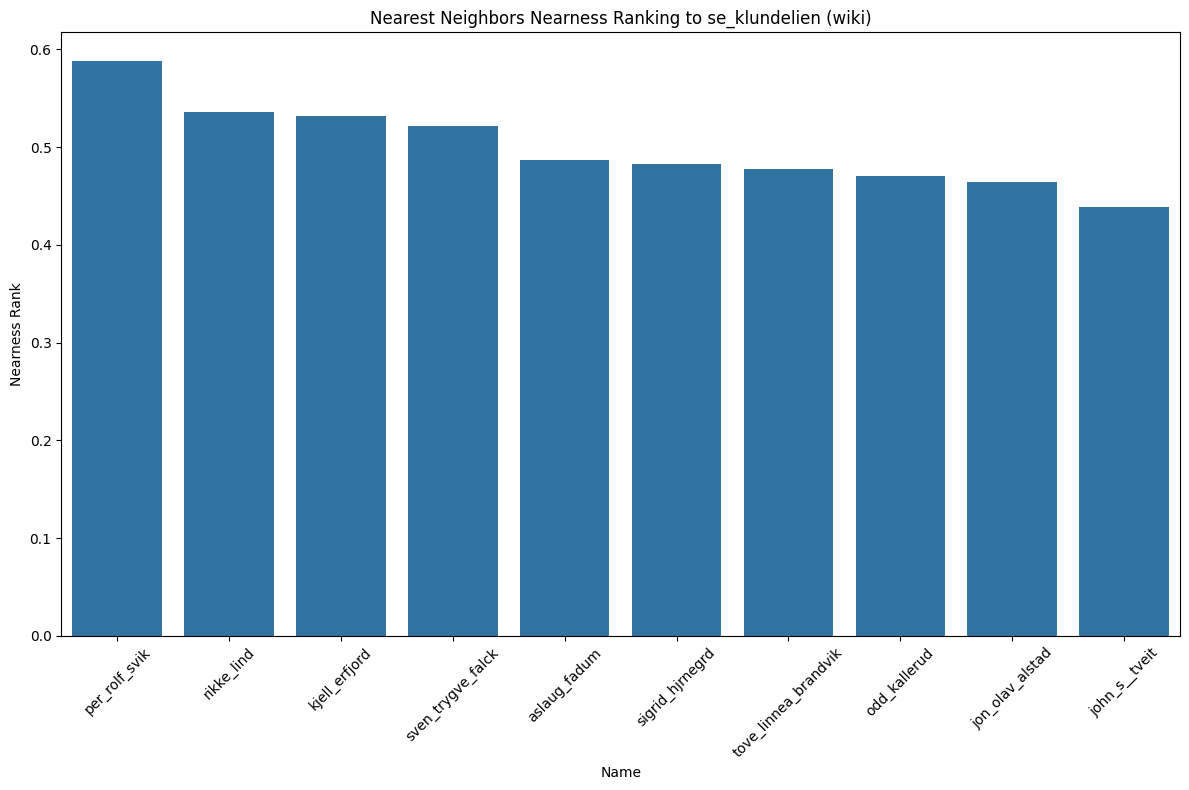

In [38]:
# plot nearest neighbors
plt.figure(figsize=(12, 8))
sns.barplot(x='name', y='nearness_rank_wiki', data=neighbors_df1)
plt.xlabel('Name')
plt.ylabel('Nearness Rank')
plt.title(f'Nearest Neighbors Nearness Ranking to {target_name} (wiki)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## P1 BoW: Nearness Ranking

In [39]:
# add column dfpedia_text and nearness_rank_dfpedia to neighbors_df
neighbors_df['dfpedia_text'] = "tbd"
neighbors_df

,wiki_text,name,nearness_rank_wiki,dfpedia_text
10,Åse Klundelien (born 8 January 1946) is a Norw...,se_klundelien,1.000000,tbd
0,Per Rolf Sævik (born 15 December 1940) is a No...,per_rolf_svik,0.588157,tbd
1,Rikke Lind (born 27 June 1968) is a Norwegian ...,rikke_lind,0.536021,tbd
5,Kjell Erfjord (born 24 July 1940) is a Norwegi...,kjell_erfjord,0.531728,tbd
2,Sven Trygve Falck (9 March 1943 – 27 August 20...,sven_trygve_falck,0.521456,tbd
7,Aslaug Fadum (17 August 1925 – 13 November 201...,aslaug_fadum,0.486808,tbd
4,Sigrid Hjørnegård (born 8 October 1965) is a N...,sigrid_hjrnegrd,0.482463,tbd
8,Tove Linnea Brandvik (born 15 November 1968) i...,tove_linnea_brandvik,0.477719,tbd
3,Odd Kallerud (20 July 1926 – 27 April 2016) wa...,odd_kallerud,0.471030,tbd
6,Jon Olav Alstad (born 9 August 1968) is a Norw...,jon_olav_alstad,0.464603,tbd


In [40]:
# add dfpedia text from names_df to neighbors_df
for index, row in neighbors_df.iterrows():
  neighbors_df.loc[index, 'dfpedia_text'] = names_df1[names_df1['name'] == row['name']]['text'].values[0]

# order by index
neighbors_df.sort_index(inplace=True)

neighbors_df

,wiki_text,name,nearness_rank_wiki,dfpedia_text
0,Per Rolf Sævik (born 15 December 1940) is a No...,per_rolf_svik,0.588157,per rolf svik born 15 december 1940 is a norwe...
1,Rikke Lind (born 27 June 1968) is a Norwegian ...,rikke_lind,0.536021,rikke lind born 27 june 1968 is a norwegian po...
2,Sven Trygve Falck (9 March 1943 – 27 August 20...,sven_trygve_falck,0.521456,sven trygve falck born 9 march 1943 is a norwe...
3,Odd Kallerud (20 July 1926 – 27 April 2016) wa...,odd_kallerud,0.471030,odd kallerud born 20 july 1926 was a norwegian...
4,Sigrid Hjørnegård (born 8 October 1965) is a N...,sigrid_hjrnegrd,0.482463,sigrid hjrnegrd born 8 october 1965 is a norwe...
5,Kjell Erfjord (born 24 July 1940) is a Norwegi...,kjell_erfjord,0.531728,kjell erfjord born 24 july 1940 is a norwegian...
6,Jon Olav Alstad (born 9 August 1968) is a Norw...,jon_olav_alstad,0.464603,jon olav alstad born 9 august 1968 is a norweg...
7,Aslaug Fadum (17 August 1925 – 13 November 201...,aslaug_fadum,0.486808,aslaug fadum born 17 august 1925 is a norwegia...
8,Tove Linnea Brandvik (born 15 November 1968) i...,tove_linnea_brandvik,0.477719,tove linnea brandvik born 15 november 1968 is ...
9,John S. Tveit (18 December 1931 – 6 September ...,john_s__tveit,0.438911,john s tveit born 18 december 1931 is a norweg...


In [41]:
# vectorize using Bag of Words
bow_matrix_dfpedia = vectorizer.fit_transform(neighbors_df['dfpedia_text'].astype(str).tolist())

# find cosine similarity between entries
target_row_dfpedia = neighbors_df[neighbors_df['name'] == target_name]
target_index_dfpedia = target_row_dfpedia.index[0]
cos_similarities_dfpedia = cosine_similarity(bow_matrix_dfpedia[target_index_dfpedia], bow_matrix_dfpedia).flatten()

# add nearness ranking to df and order by nearness
neighbors_df['nearness_rank_dfpedia'] = cos_similarities_dfpedia
neighbors_df.sort_values(by='nearness_rank_dfpedia', ascending=False, inplace=True,)

neighbors_df

,wiki_text,name,nearness_rank_wiki,dfpedia_text,nearness_rank_dfpedia
10,Åse Klundelien (born 8 January 1946) is a Norw...,se_klundelien,1.000000,se klundelien born 8 january 1946 is a norwegi...,1.000000
0,Per Rolf Sævik (born 15 December 1940) is a No...,per_rolf_svik,0.588157,per rolf svik born 15 december 1940 is a norwe...,0.561349
1,Rikke Lind (born 27 June 1968) is a Norwegian ...,rikke_lind,0.536021,rikke lind born 27 june 1968 is a norwegian po...,0.532373
2,Sven Trygve Falck (9 March 1943 – 27 August 20...,sven_trygve_falck,0.521456,sven trygve falck born 9 march 1943 is a norwe...,0.515142
3,Odd Kallerud (20 July 1926 – 27 April 2016) wa...,odd_kallerud,0.471030,odd kallerud born 20 july 1926 was a norwegian...,0.502919
4,Sigrid Hjørnegård (born 8 October 1965) is a N...,sigrid_hjrnegrd,0.482463,sigrid hjrnegrd born 8 october 1965 is a norwe...,0.490556
5,Kjell Erfjord (born 24 July 1940) is a Norwegi...,kjell_erfjord,0.531728,kjell erfjord born 24 july 1940 is a norwegian...,0.477393
6,Jon Olav Alstad (born 9 August 1968) is a Norw...,jon_olav_alstad,0.464603,jon olav alstad born 9 august 1968 is a norweg...,0.472931
7,Aslaug Fadum (17 August 1925 – 13 November 201...,aslaug_fadum,0.486808,aslaug fadum born 17 august 1925 is a norwegia...,0.472759
8,Tove Linnea Brandvik (born 15 November 1968) i...,tove_linnea_brandvik,0.477719,tove linnea brandvik born 15 november 1968 is ...,0.463099


In [42]:
# make a copy
neighbors_df2 = neighbors_df.copy()

In [43]:
# reset index and drop target name
neighbors_df2.reset_index(drop=True, inplace=True)
neighbors_df2.drop(neighbors_df2[neighbors_df2['name'] == target_name].index, inplace=True)

neighbors_df2

,wiki_text,name,nearness_rank_wiki,dfpedia_text,nearness_rank_dfpedia
1,Per Rolf Sævik (born 15 December 1940) is a No...,per_rolf_svik,0.588157,per rolf svik born 15 december 1940 is a norwe...,0.561349
2,Rikke Lind (born 27 June 1968) is a Norwegian ...,rikke_lind,0.536021,rikke lind born 27 june 1968 is a norwegian po...,0.532373
3,Sven Trygve Falck (9 March 1943 – 27 August 20...,sven_trygve_falck,0.521456,sven trygve falck born 9 march 1943 is a norwe...,0.515142
4,Odd Kallerud (20 July 1926 – 27 April 2016) wa...,odd_kallerud,0.471030,odd kallerud born 20 july 1926 was a norwegian...,0.502919
5,Sigrid Hjørnegård (born 8 October 1965) is a N...,sigrid_hjrnegrd,0.482463,sigrid hjrnegrd born 8 october 1965 is a norwe...,0.490556
6,Kjell Erfjord (born 24 July 1940) is a Norwegi...,kjell_erfjord,0.531728,kjell erfjord born 24 july 1940 is a norwegian...,0.477393
7,Jon Olav Alstad (born 9 August 1968) is a Norw...,jon_olav_alstad,0.464603,jon olav alstad born 9 august 1968 is a norweg...,0.472931
8,Aslaug Fadum (17 August 1925 – 13 November 201...,aslaug_fadum,0.486808,aslaug fadum born 17 august 1925 is a norwegia...,0.472759
9,Tove Linnea Brandvik (born 15 November 1968) i...,tove_linnea_brandvik,0.477719,tove linnea brandvik born 15 november 1968 is ...,0.463099
10,John S. Tveit (18 December 1931 – 6 September ...,john_s__tveit,0.438911,john s tveit born 18 december 1931 is a norweg...,0.452201


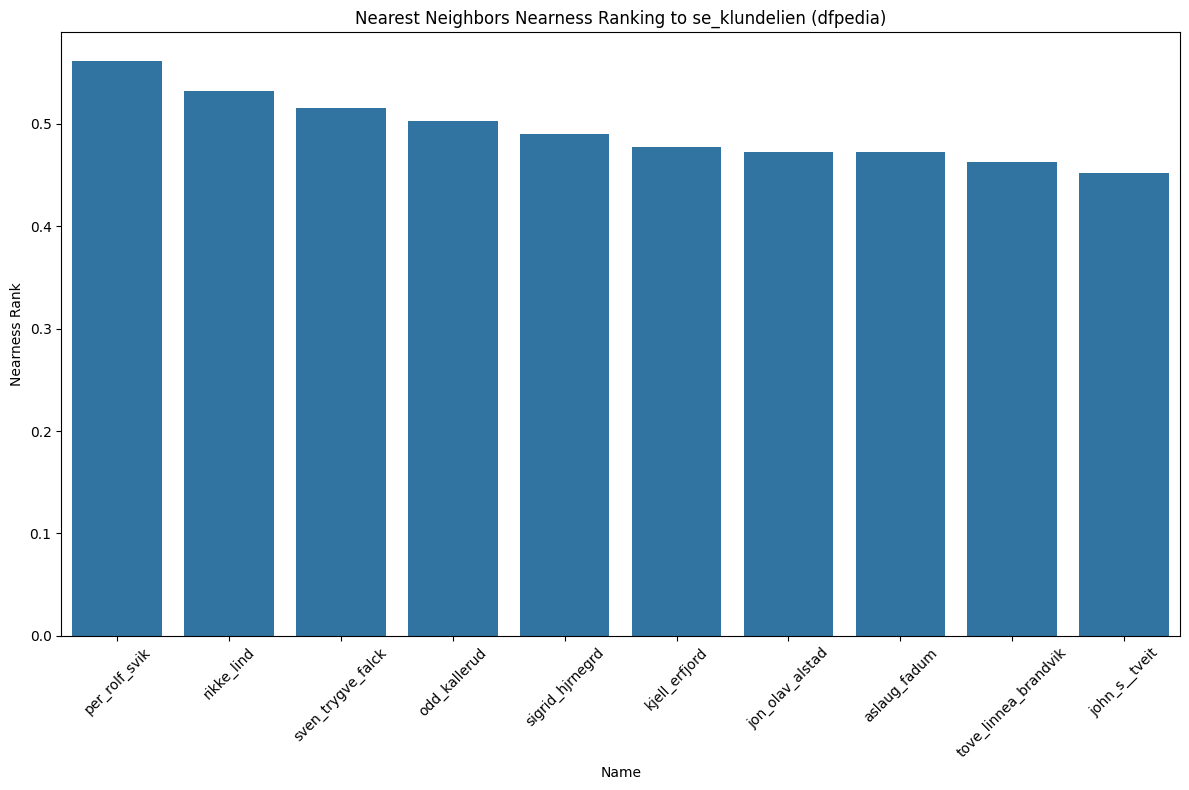

In [44]:
# plot nearness neighbors from dfpedia
plt.figure(figsize=(12, 8))
sns.barplot(x='name', y='nearness_rank_dfpedia', data=neighbors_df2)
plt.xlabel('Name')
plt.ylabel('Nearness Rank')
plt.title(f'Nearest Neighbors Nearness Ranking to {target_name} (dfpedia)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Part 3)


##Interactive Cell

Make an interactive notebook where a user can choose or enter a name and the notebook displays the 10 closest individuals.

In addition to presenting the project slides, at the end of the presentation each student will demonstrate their code using a famous person suggested by the other students that exists in the DBpedia set.


Make a drop down text box where you can select or type in a name from names_df and find the 10 closest neighbors

In [ ]:
# make list of names from names_df
names_df.sort_values(by='name', inplace=True)
for index, row in names_df.head(30).iterrows():
  if '%' in row['name']:
    encoded_name = row['name']
    decoded_name = urllib.parse.unquote(encoded_name)
    names_df.loc[index, 'name'] = decoded_name
  else:
    pass

names_list = names_df['name'].tolist()
names_list

# make dropdown list
dropdown = widgets.Combobox(
    placeholder = 'type here',
    options = names_list,
    description='Select a name:',
    ensure_option=True,
    disabled=False
)

# display the dropdown
display(dropdown)

# bank the selection
def on_select(change):
  global selection
  print(f"You selected: {change.new}")
  selection = change.new

dropdown.observe(on_select, names='value')

# find corresponding name in names_df1
selection_name = names_df1[names_df['name'] == selection]['name'].values[0]

# target row
selection_row = names_df1[names_df1['name'] == selection_name]

# vectorize using Bag of Words
bow_matrix = vectorizer.fit_transform(all_text)

# find cosine similarity between entries
target_index = selection_row.index[0]
selection_cos_similarities = cosine_similarity(bow_matrix[target_index], bow_matrix).flatten()

# get top 10 similar people (excluding self)
selection_similar_indices = selection_cos_similarities.argsort()[-11:-1][::-1]
selection_similar_people = names_df1.iloc[selection_similar_indices][['name', 'text']]

# return similar people
print(f"\nTop 10 people similar to '{selection_name}':")
for i, row in selection_similar_people.iterrows():
    print(f"- {row['name']}")

# sentiment analysis of target person's overview
selection_overview = selection_row['text'].values[0]
selection_sentiment = TextBlob(selection_overview).sentiment
print(f"\nSentiment of {selection_name}'s overview:")
print(f"Polarity: {selection_sentiment.polarity:.2f}, Subjectivity: {selection_sentiment.subjectivity:.2f}")